In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

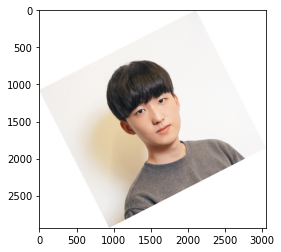

In [2]:
# Ver. Rotated Picture
my_image_path = os.getenv('HOME')+'/aiffel/exp3/images/me_rot.jpg'
img_bgr = cv2.imread(my_image_path) 
img_show = img_bgr.copy()

detector_hog = dlib.get_frontal_face_detector()
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)

plt.imshow(img_rgb)
plt.show()

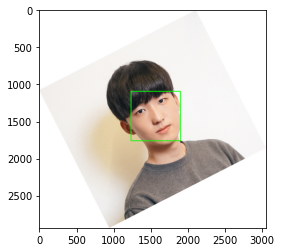

In [3]:
# Draw Rectangle (Detected Face Area)
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 10, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

plt.imshow(img_show_rgb)
plt.show()

In [4]:
# Import the Model
model_path = os.getenv('HOME')+'/aiffel/exp3/models/sp6flm.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [5]:
# Find Number of Landmarks
list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


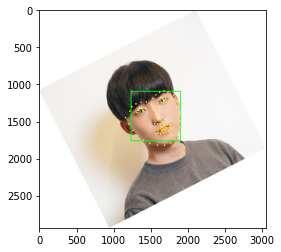

In [6]:
# Draw Points (Detected Landmarks)
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 10, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [7]:
# Function : Add Sticker on the Image
def image_add_sticker(sticker_path,lm,halign,valign):
    # Arg 1. Path of The Sticker Image
    # Arg 2.  Landmark Index
    # Arg 3.  Horizontal Align (left:-1, center:0, right:1)
    # Arg 4.  Vertical Align (top:-1, middle:0, bottom:1)
    
    # Function : Get Refined X, Y
    def sticker_get_pos(x,y,halign,valign):
        refined_x = x - (1 + halign)*(w // 2)
        refined_y = y - (1 + valign)*(h // 2)

        if refined_x < 0: 
            img_sticker = img_sticker[:, -refined_x:]
            refined_x = 0
        if refined_y < 0:
            img_sticker = img_sticker[-refined_y:, :]
            refined_y = 0

        return refined_x, refined_y

    
    # Assign Position of the Landmark
    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
        print (landmark[lm])
        x = landmark[lm][0]
        y = landmark[lm][1]
        w = h = dlib_rect.width()
        print ('(x,y) : (%d,%d)'%(x,y))
        print ('(w,h) : (%d,%d)'%(w,h))
    
    # Load & Resize Sticker
    img_sticker = cv2.imread(sticker_path)
    img_sticker = cv2.resize(img_sticker, (w,h))
    
    #Get Angle (atan to 0~360)
    def get_angle(start_x, start_y, end_x, end_y):
        dy = end_y-start_y
        dx = end_x-start_x
        angle = math.atan(dy/dx) * (180/math.pi)
        angle = 90 - angle
        if(dx < 0):
            angle += 180
        else:
            if(dy < 0): angle += 360
            
        return angle

    # Rotate the Image
    import math
    rot = get_angle(landmark[27][0],landmark[27][1],landmark[8][0],landmark[8][1])
    matrix = cv2.getRotationMatrix2D(((1 + halign)*(w // 2), (1 + valign)*(h // 2)), rot, 1)
    img_sticker = cv2.warpAffine(img_sticker, matrix, (w, h))
    
    print(rot)
    
    # Get Refined Position 
    refined_x, refined_y = sticker_get_pos(x,y,halign,valign)
    
    # Make Debugging Image 
    sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
    img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
        np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
    
    # Make Production Image
    sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
    img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
        np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

In [8]:
# Add Rabbit Nose Sticker
image_add_sticker(os.getenv('HOME')+'/aiffel/exp3/images/rabbit_nose.png',30,0,0)

(1603, 1471)
(x,y) : (1603,1471)
(w,h) : (667,667)
26.477174283540755


In [9]:
# Add Rabbit Ears Sticker
image_add_sticker(os.getenv('HOME')+'/aiffel/exp3/images/rabbit_ears.png',27,0,1)

(1519, 1272)
(x,y) : (1519,1272)
(w,h) : (667,667)
26.477174283540755


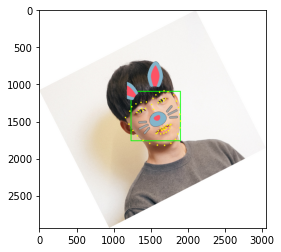

In [10]:
# Show Debugging Image
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

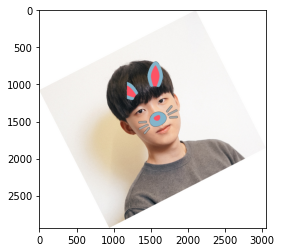

In [11]:
# Show Production Image
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

In [12]:
"""
Q. 얼굴 각도에 따라 스티커가 어떻게 변해야할까요?
    A. 얼굴 각도에 따라 스티커의 X, Y Scale이 바뀌어야 하며, 그 외에도 원근감에 맞도록 이미지가 변형되어야 한다.
Q. 멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?
    A. 멀리서 촬영하면 정밀한 Face Detection이 어려울 뿐더러, Sticker의 사이즈도 변화해야 한다.
       옆으로 누워서 촬영해도 마찬가지로 Face Detection과 스티커를 합성하는 과정에서 Rotation 과정이 필요하다.
Q. 실행 속도가 중요할까요?
    A. 단순히 단일 이미지 합성이라면 실행 속도는 크게 중요하지 않을듯 하다.
       그러나, 이미지가 실시간으로 변화하는 서비스(ex, 스티커 카메라 앱)을 만드는 경우 실행속도는 중요하다.
Q. 스티커앱을 만들 때 정확도가 얼마나 중요할까요?
    A. 정확도가 높을수록 스티커의 위치가 자연스러워지므로 결과 이미지의 퀄리티가 높아진다.
       스티커 앱의 경우 결과 이미지의 품질이 서비스 만족도의 대부분을 차지한다. 
       그만큼 정확도의 중요도가 높은 편이다.
"""


'\nQ. 얼굴 각도에 따라 스티커가 어떻게 변해야할까요?\n    A. 얼굴 각도에 따라 스티커의 X, Y Scale이 바뀌어야 하며, 그 외에도 원근감에 맞도록 이미지가 변형되어야 한다.\nQ. 멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?\n    A. 멀리서 촬영하면 정밀한 Face Detection이 어려울 뿐더러, Sticker의 사이즈도 변화해야 한다.\n       옆으로 누워서 촬영해도 마찬가지로 Face Detection과 스티커를 합성하는 과정에서 Rotation 과정이 필요하다.\nQ. 실행 속도가 중요할까요?\n    A. 단순히 단일 이미지 합성이라면 실행 속도는 크게 중요하지 않을듯 하다.\n       그러나, 이미지가 실시간으로 변화하는 서비스(ex, 스티커 카메라 앱)을 만드는 경우 실행속도는 중요하다.\nQ. 스티커앱을 만들 때 정확도가 얼마나 중요할까요?\n    A. 정확도가 높을수록 스티커의 위치가 자연스러워지므로 결과 이미지의 퀄리티가 높아진다.\n       스티커 앱의 경우 결과 이미지의 품질이 서비스 만족도의 대부분을 차지한다. \n       그만큼 정확도의 중요도가 높은 편이다.\n'